## Unique Characteristics: Using Shapley Values

In [1]:
import os
os.chdir("..")

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from itertools import product
from sklearn.ensemble import RandomForestRegressor
from shap import TreeExplainer, Explanation
from shap.plots import waterfall
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from kneed import KneeLocator

from utils import synthetic_data_generation as sd
from utils.Thesis_models import *
from utils import Thesis_viz as viz

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


WARNING  [module_wrapper.py:149] From C:\Users\htals\AppData\Roaming\Python\Python311\site-packages\tensorflow_probability\python\internal\backend\numpy\_utils.py:48: The name tf.logging.TaskLevelStatusMessage is deprecated. Please use tf.compat.v1.logging.TaskLevelStatusMessage instead.



WARNING  [module_wrapper.py:149] From C:\Users\htals\AppData\Roaming\Python\Python311\site-packages\tensorflow_probability\python\internal\backend\numpy\_utils.py:48: The name tf.control_flow_v2_enabled is deprecated. Please use tf.compat.v1.control_flow_v2_enabled instead.



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a

WARNING  [module_wrapper.py:149] From C:\Users\htals\AppData\Roaming\Python\Python311\site-packages\keras\src\utils\tf_utils.py:585: The name tf.executing_eagerly_outside_functions is deprecated. Please use tf.compat.v1.executing_eagerly_outside_functions instead.

WARNING  [optimizer.py:123] `lr` is deprecated in Keras optimizer, please use `learning_rate` or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.
WARNING  [optimizer.py:123] `lr` is deprecated in Keras optimizer, please use `learning_rate` or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.
The `lr` argument is deprecated, use `learning_rate` instead.


In [3]:
def run_model(model, all_args):
    arg_names = model.__code__.co_varnames[:model.__code__.co_argcount]
    model_args = {k: all_args[k] for k in arg_names if k in all_args}
    return model(**model_args)

def get_reduced_data(label_df, column_break):
    
    zone_indices = {zone : list(label_df[label_df[column_break] == zone].index) \
                                                for zone in np.unique(label_df[column_break])}
    mapping_dict = {value: key for key, values in zone_indices.items() for value in values}
    data = df.copy()
    data['gE_new'] = df['gV'].map(mapping_dict)
    
    return data

### Synthetic data parameters

In [4]:
seed = 50
mode = 'both'
effective_groups = 5
visible_groups = 200
number_of_contineous_features = 5

# random_effects_distribution = 'normal'; re_intercept = (0,5) ; re_slope = (0,5)
random_effects_distribution = 'linspace'; re_intercept = (-10,10) ; re_slope = (-10,10)

# error_type = 'on_group' ; re_error = (0,3)
error_type = 'on_target' ; re_error = (0,3)

shuffle_groups = False

### Synthetic data generation

In [5]:
df,_ = sd.create_data(
    n = 1000,
    n_effective_groups = effective_groups,
    n_visible_groups = visible_groups,
    n_contineous_features = 5,
    mode = mode,
    fixed_slope = (0, 1),
    fixed_intercept = 0,
    fixed_error=(0, 1),
    random_effects_distribution = random_effects_distribution,
    re_intercept = (-10, 10),
    re_slope = (-10, 10),
    error_type = error_type,
    re_error = (0, 3),
    random_seed = seed,
    shuffle_groups = shuffle_groups,
    show_random_effects = False
)
df

,f0,f1,f2,f3,f4,gE,gV,y
0,-0.010797,-0.543834,-0.489052,-0.207340,-0.245370,0,0,-3.695253
1,0.993148,-0.183606,0.543788,0.521073,-0.379981,0,0,-23.659988
2,-0.306918,-0.296470,-0.709066,0.945329,0.818357,0,0,-16.675451
3,0.119914,-0.372819,0.776400,0.349146,-0.217825,0,0,-21.283745
4,0.014368,0.048207,0.856002,0.142746,0.336675,0,0,-17.754629
...,...,...,...,...,...,...,...,...
995,-0.033881,0.289258,-0.238024,-0.035100,-0.829667,4,199,-2.581987
996,-0.738472,0.534579,0.588378,0.741214,-0.074996,4,199,24.790728
997,-0.348035,0.139808,-0.035477,0.023636,0.497246,4,199,11.455646
998,-0.073908,-0.417275,0.667721,-0.814868,-0.946318,4,199,0.056477


### Choose a model

In [6]:
# [MixedLM, LMMNN, LinearOHE, MERForest, ARMED]
Model = MERForest

### Model Performance with Effective Groups and Visible Groups

In [7]:
mse_with_Effective_groups = run_model(Model, {'df': df,'mode':mode,'to_drop':'gV'})[0]
mse_with_Visible_groups   = run_model(Model, {'df': df,'mode':mode,'to_drop':'gE'})[0]
print("MSE_Effective_groups: ", mse_with_Effective_groups)
print("MSE_Visible_groups: ", mse_with_Visible_groups)

MSE_Effective_groups:  21.41530746371904
MSE_Visible_groups:  26.012093923845047


### Using Shap Explainer, calcualting mean absolute shapley values per each group

In [8]:
start = time.time()

In [9]:
shap_df = pd.DataFrame([])

X = df.drop(['gE','y'],axis=1)
y = df['y']
model = RandomForestRegressor()
model.fit(X, y)
explainer = TreeExplainer(model)

for i in range(len(df.gV.unique())):
    
    sv = explainer(X[X.gV == i])
    exp = Explanation(sv.values, sv.base_values, data=X[X.gV == i].values, feature_names=X.columns)
    shapley_values = pd.DataFrame(sv.values, columns=X.columns)
    
    for col in [col for col in shapley_values.columns]:
        
        shap_df.at[i,col] = np.mean(np.absolute(shapley_values[col]))
        
shap_df

,f0,f1,f2,f3,f4,gV
0,1.632057,1.701049,0.501605,1.181953,0.467046,13.137445
1,2.771455,3.226449,0.401699,0.858258,2.013648,14.473501
2,2.398909,3.182155,0.228368,0.666448,1.715078,11.549379
3,2.439554,1.836702,0.553294,0.856906,1.388152,11.489360
4,2.240424,3.136390,0.486461,0.980074,1.751232,8.082786
...,...,...,...,...,...,...
195,1.046365,0.392991,2.238604,2.209362,2.436765,12.803826
196,1.374333,0.368371,2.976715,2.626367,2.786162,10.536647
197,1.178245,0.320899,2.177731,3.117133,3.462608,7.817194
198,0.715211,0.302619,2.540248,3.459787,2.099346,13.520354


### Clustering with KMeans

In [10]:
K_range = range(2, 11)

In [11]:
X = np.array(shap_df.loc[:,[col for col in shap_df.columns if not col.startswith('g')]])
pca = PCA(n_components=2)
pca.fit(X)

X_transformed = pca.transform(X)
pca_df = pd.DataFrame(X_transformed, columns = [f'pca_'+str(i) for i in range(X_transformed.shape[1])])
X = np.array(pca_df)

for k in K_range:
    
    kmeans = KMeans(n_clusters= k, random_state=42)
    labels = kmeans.fit_predict(X)
    pca_df['K-'+str(k)] = labels

In [12]:
res = pd.DataFrame([])

for itr, i in enumerate([col for col in pca_df.columns if col.startswith('K')]):
       
    reduced_df = get_reduced_data(pca_df, i)
    reduced_df.drop(['gE','gV'], axis=1, inplace=True)
    
    try:
        test_mse = run_model(Model, {'df': reduced_df,'mode':mode})[0]
        res.at[itr, 'name'] = i
        res.at[itr, 'test_mse'] = test_mse
        
    except np.linalg.LinAlgError: pass

In [13]:
res

,name,test_mse
0,K-2,51.662705
1,K-3,43.012687
2,K-4,26.596826
3,K-5,24.142496
4,K-6,23.291470
5,K-7,29.080907
6,K-8,25.317142
7,K-9,41.212198
8,K-10,31.744879


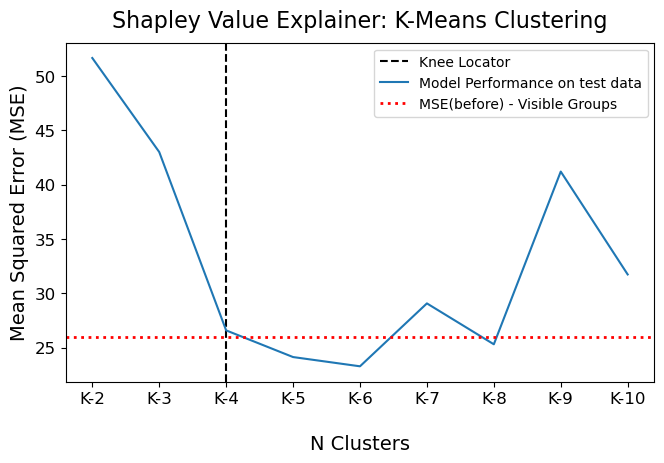

In [14]:
fig, ax = plt.subplots(figsize = (7,5), dpi = 100)
results = res.copy()
results.reset_index(drop=True, inplace=True)

try:
    kn = KneeLocator(results.index, results['test_mse'], curve='convex', direction='decreasing')
    plt.axvline(x=results[results.test_mse == kn.knee_y].index[0], color='k', linestyle='--', label='Knee Locator')
except ValueError: pass

ax.plot(results.name, results.test_mse,  label='Model Performance on test data')

plt.axline((0, mse_with_Visible_groups), (1, mse_with_Visible_groups), color = 'r', ls=':', linewidth = 2, label = 'MSE(before) - Visible Groups')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend()
ax.set_title("Shapley Value Explainer: K-Means Clustering", fontsize = 16, y = 1.02)
ax.set_xlabel('\nN Clusters', fontsize = 14)
ax.set_ylabel("Mean Squared Error (MSE)", fontsize = 14)
plt.tight_layout(pad = 2)
# plt.savefig(r"Figures\Unique_Characteristics_Shapley_value_clustering_KMeans.pdf", format = 'pdf',bbox_inches='tight')
plt.show()

In [15]:
end = time.time()
np.round((end-start),2)

41.67

In [16]:
data = get_reduced_data(pca_df, 'K-5')
print("Clustered groups \n")

zone_indices_optics = {zone : list(np.unique(data[data['gE_new'] == zone]['gV'])) for zone in np.unique(data.gE_new)}
for i in np.unique(data.gE_new):
    print(i," : ",zone_indices_optics[i],'\n')

Clustered groups 

0  :  [42, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 127] 

1  :  [160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199] 

2  :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 

3  :  [120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 167, 172] 

4  :  [0, 19, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79] 



In [17]:
print("Original Group Memberships \n")
zone_indices_actual = {zone : list(np.unique(df[df['gE'] == zone]['gV'])) for zone in np.unique(df.gE)}
for i in np.unique(df.gE):
    print(i," : ",zone_indices_actual[i],'\n')

Original Group Memberships 

0  :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 

1  :  [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79] 

2  :  [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119] 

3  :  [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159] 

4  :  [160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199] 

